This the first tutorial of the *AcoustiX*, where all the basic api and functions are explained. All the api preseneted in this tutorials will be very general that can be extended to any physical problems solved by FEM.

- First, add the library into the current PATH in order to be used

In [1]:
import sys
sys.path.append('/home/shaoqi/Devlop/PyXfem/PyAcoustiX/')  # add the path of PyAcoustiX
# import other common python packages
import numpy as np
import matplotlib.pyplot as plt

#### Mesh creating api

In [2]:
from acxfem.mesh import Mesh1D  # import the class Mesh1D from PyAcoustiX, only 1D mesh is available now.
num_elems = 10  # number of elements, here the element is a concept of geometry, not FEM element involving interpolation order
num_nodes = num_elems + 1  # number of nodes
nodes = np.linspace(-1, 1, num_nodes)
# create the connnectivity that is used to define the mesh
elem_connec1 = np.arange(0, num_elems)
elem_connec2 = np.arange(1, num_nodes)
connectivity = np.vstack((elem_connec1, elem_connec2)).T  # this connectivity can be obtained from other meshing software as Gmsh
# call mesh constructor
mesh = Mesh1D(nodes, connectivity)
# call mesh method to generate the mesh
mesh.get_mesh()

{0: array([-1. , -0.8]),
 1: array([-0.8, -0.6]),
 2: array([-0.6, -0.4]),
 3: array([-0.4, -0.2]),
 4: array([-0.2,  0. ]),
 5: array([0. , 0.2]),
 6: array([0.2, 0.4]),
 7: array([0.4, 0.6]),
 8: array([0.6, 0.8]),
 9: array([0.8, 1. ])}

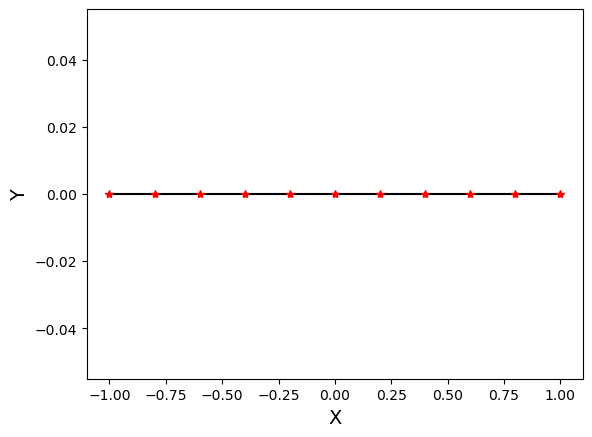

In [3]:
# we are plot the mesh by calling
mesh.plotmesh(withnode=True)  # two options are available: 'withnode' indicator and 'withnodeid' indicator

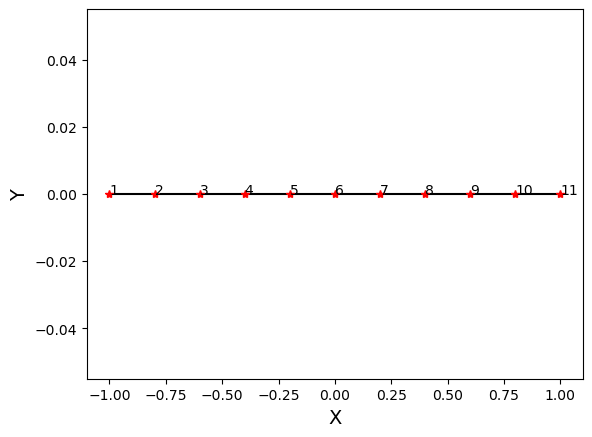

In [4]:
mesh.plotmesh(withnode=True, withnodeid=True)

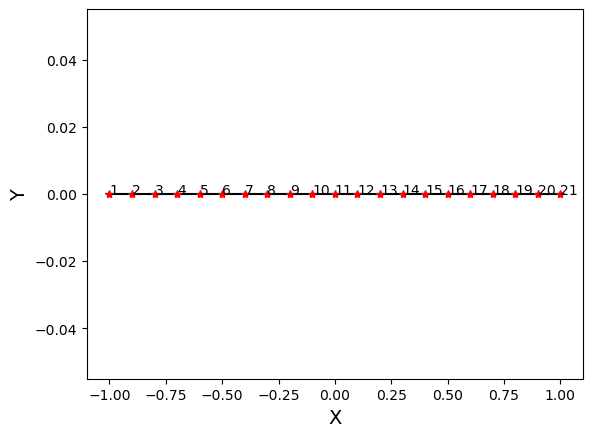

In [5]:
# we can also refine the mesh by calling
mesh.refine_mesh(1)  # refine the mesh by 2 times
# and we plot the refined mesh
# mesh.plotmesh(withnode=True, withnodeid=True)
mesh.get_mesh()
mesh.plotmesh(withnode=True, withnodeid=True)

There are many other apis that you can discover by yourself in `mesh.py` file. 



#### Api for construct the FEM space on defined mesh

In [6]:
from acxfem.basis import Lobbato1DElement  # here we import the 1D Lobbato element from PyAcoustiX
"""here we will introduce the first and may be the biggiest difference 
between PyAcoustiX and other FEM software when defining the FEM space:
the interpolation order can be varied on each element (aniostropic elements)"""
bases = []  # basis applied on each element, could be different order and type
for key, elem in mesh.get_mesh().items():
    # we can give a random interpolation order for each element
    order = np.random.randint(1, 5)
    basis = Lobbato1DElement('U', order, elem)
    print(f"element {key} has interpolation order {order}")
    bases.append(basis)

element 0 has interpolation order 4
element 1 has interpolation order 3
element 2 has interpolation order 4
element 3 has interpolation order 3
element 4 has interpolation order 2
element 5 has interpolation order 2
element 6 has interpolation order 1
element 7 has interpolation order 1
element 8 has interpolation order 2
element 9 has interpolation order 3
element 10 has interpolation order 3
element 11 has interpolation order 2
element 12 has interpolation order 1
element 13 has interpolation order 4
element 14 has interpolation order 1
element 15 has interpolation order 3
element 16 has interpolation order 2
element 17 has interpolation order 3
element 18 has interpolation order 3
element 19 has interpolation order 1


we can pick certain element basis to illustrate the anitropic FEM space.

In [7]:
bases[1].ke  # order 2-> 3x3 matrix

array([[ 10., -10.,   0.,   0.],
       [-10.,  10.,   0.,   0.],
       [  0.,   0.,  20.,   0.],
       [  0.,   0.,   0.,  20.]])

In [8]:
bases[17].ke  # order 4-> 5x5 matrix

array([[ 10., -10.,   0.,   0.],
       [-10.,  10.,   0.,   0.],
       [  0.,   0.,  20.,   0.],
       [  0.,   0.,   0.,  20.]])

#### define materials and subdomains
marerials are defined by in `material.py` file as classes. For this moment, pure fluid materials as air, water and equivalent fluid can be defined. Isotropic solid materials and poro-elastic materials with JCA micro-geometric model are also supported. The material parameters is spatially constant but could be frequency dependent (porous mterials).

supported material types:
- air
- fluid
- porous materials: equivalent fluid (Biot-JCA model)
- isotropic elastic solid
- poro-elastic material (Limp model)
- poro-elastic material (Biot-JCA model)

In [10]:
# defineing a air material
from acxfem.materials import Air
air = Air('normal_air')  # only the label of the material is required, other parameters are default
from acxfem.materials import ElasticMaterial
# defineing a solid material
rubber = ElasticMaterial('rubber', 1e6, 0.3, 1000, 0.01)  # label, Young's modulus, density, Poisson's ratio, damping loss factor
# defineing a poro-elastic material
from acxfem.materials import PoroElasticMaterial
phi          = 0.99  # porosity
sigma        = 1.0567e4 # resistivity
alpha        = 1.2  # Tortuosity
Lambda_prime = 490e-6  # Viscous characteristic length
Lambda      = 240e-6  # 
rho_1 = 9.2  # solid density
nu = 0.285  # Poisson's ratio
E = 3.155e5 # Young's modulus
eta = 0.032  # damping loss factor
foam = PoroElasticMaterial('foam', phi, sigma, alpha, Lambda_prime, Lambda, rho_1, E, nu, eta)  # label, Young's modulus, density, Poisson's ratio, damping loss factor, permeability, porosity, viscous loss factor

# for the material of frequency dependent, the material properties will update with the frequency
# the `set_frequency` method is used to update the material properties
freq = 1000  # frequency in Hz
omega = 2 * np.pi * freq  # angular frequency
print("air density at frequency 0 Hz is", air.rho)
air.set_frequency(omega)
print("air density at frequency 1000 Hz is", air.rho)

air density at frequency 1000 Hz is 1.213
air density at frequency 1000 Hz is 1.213


we see that the frequency does not the the density of air. 
but what about the poro-elastic materials?

In [12]:
foam.set_frequency(0.1)
print("foam density at frequency 0 Hz is", foam.rho_f)
foam.set_frequency(omega)
print("foam density at frequency 1000 Hz is", foam.rho_f)

foam density at frequency 0 Hz is (1.577996764939937-105670.00000005488j)
foam density at frequency 1000 Hz is (1.5777775349498746-1.6852208541718068j)


It is noted that the density of the poro-elastic materials changes a lot under different frequency

Now, the materials are defined, we can assign the defined materials to different subdomains of the problems.

To constrcut the subdomains, we need to define the elements that are occupied by the materials.


In [14]:
air_elements = np.arange(0, int(num_elems/2))
foam_elements = np.arange(int(num_elems/2), num_elems)
subdomains = {air: air_elements, foam: foam_elements}
print('air_elements: ', air_elements)
print('foam_elements: ', foam_elements)

air_elements:  [0 1 2 3 4]
foam_elements:  [5 6 7 8 9]


Before using the defined subdomain, it is necessary to check if the materials are compatible togather. This will use a utility function `check_materials_compatibility` in `utilities.py` file. 

In [15]:
from acxfem.utilities import check_material_compability
check_material_compability(subdomains)

Material models normal_air are compatible, computation continues ...
Material models foam are compatible, computation continues ...


Until now, we have seen all the basic api for constructing the FEM space. Now, we can construct the FEM space and solve a real physical problem by FEM.

See the tutorial 1 for more details.